# Impact of the geometry on HPL performance

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
import re
warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'results.csv')
    res['start_timestamp'] = pandas.to_datetime(res['start_timestamp'])
    res['start'] = res['start_timestamp'] - res['start_timestamp'].min()
    return res

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    expfiles = info['expfile']
    dgemm_file = [f for f in expfiles if f.endswith('.yaml')]
    assert len(dgemm_file) == 1
    result['dgemm_file'] = dgemm_file[0]
    result['platform'] = get_platform(name)
    install_opt = get_yaml(name, info['installfile'])
    result['model'] = 'complex_model' if install_opt['stochastic_network'] else 'simple_model'
    return result

simulation_dir = ['geometry/13/', 'geometry/15']
simulation_files = [os.path.join(simdir, f) for simdir in simulation_dir for f in os.listdir(simdir) if f.endswith('.zip')]

reality_dir = ['../hpl/geometry/4']
reality_files = [os.path.join(realdir, f) for realdir in reality_dir for f in os.listdir(realdir) if f.endswith('.zip')]

dfreal = pandas.concat([read_result(a) for a in reality_files])
dfreal['mode'] = 'reality'

df = pandas.concat([read_sim_result(f) for f in simulation_files])
df['mode'] = 'simulation'
df = pandas.concat([df, dfreal])

df['nb_nodes'] = df['proc_p'] * df['proc_q']
df['geometry'] = df['proc_p'].astype(str) + '×' + df['proc_q'].astype(str)
df.head()

,application_time,bcast,block_size,cpu_utilization,depth,dgemm_file,filename,gflops,major_page_fault,matrix_size,...,start,start_timestamp,stop_timestamp,swap,sys_time,thread_per_process,time,usr_time,nb_nodes,geometry
0,822.537,2,128,0.99,1,dgemm_128.yaml,geometry/13/nancy_2020-06-27_2629344.zip,20730.0,0.0,250000,...,NaT,NaT,NaN,0,1300.78,1,502.50,7106.33,960,64×15
1,1047.260,2,128,0.99,1,dgemm_128.yaml,geometry/13/nancy_2020-06-27_2629344.zip,15300.0,0.0,250000,...,NaT,NaT,NaN,0,1567.36,1,680.98,8708.80,960,120×8
2,891.209,2,128,0.99,1,dgemm_128.yaml,geometry/13/nancy_2020-06-27_2629344.zip,18420.0,0.0,250000,...,NaT,NaT,NaN,0,1243.26,1,565.40,7026.93,960,80×12
3,255.104,2,128,0.99,1,dgemm_128.yaml,geometry/13/nancy_2020-06-27_2629344.zip,19620.0,0.0,250000,...,NaT,NaT,NaN,0,112.24,1,530.89,1387.26,960,4×240
0,1748.040,2,128,0.99,1,dgemm_128.yaml,geometry/13/nancy_2020-06-27_2629349.zip,10390.0,0.0,250000,...,NaT,NaT,NaN,0,3666.71,1,1002.27,15214.70,960,192×5


In [2]:
dumped_cols = ['filename', 'matrix_size', 'proc_p', 'proc_q', 'mode', 'time', 'gflops']
df[dumped_cols].to_csv('/tmp/hpl_geometry.csv', index=False)

### Checking the parameters

In [3]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes', 'start',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp', 'dgemm_file', 'platform_id',
                  'theoretical_peak', 'theoretical_smart_peak'}
colnames = set(df) - name_exceptions
df.groupby(list(colnames))[['swap']].count()

swap
rfact proc_q geometry pfact bcast mem_align nb_nodes process_per_node proc_p block_size thread_per_process depth swap      
2     1      960×1    1     2     8         960      32               960    128        1                  1     0        8
      2      480×2    1     2     8         960      32               480    128        1                  1     0        8
      3      320×3    1     2     8         960      32               320    128        1                  1     0        8
      4      240×4    1     2     8         960      32               240    128        1                  1     0        8
      5      192×5    1     2     8         960      32               192    128        1                  1     0        8
      6      160×6    1     2     8         960      32               160    128        1                  1     0        8
      8      120×8    1     2     8         960      32               120    128        1                  1     0        8
      10     96×10    1     2     8         960      32               96     128        1                  1     0        8
      12     80×12    1     2     8         960      32               80     128        1                  1     0        8
      15     64×15    1     2     8         960      32               64     128        1                  1     0        8
      16     60×16    1     2     8         960      32               60     128        1                  1     0        8
      20     48×20    1     2     8         960      32               48     128        1                  1     0        8
      24     40×24    1     2     8         960      32               40     128        1                  1     0        8
      30     32×30    1     2     8         960      32               32     128        1                  1     0        8
      32     30×32    1     2     8         960      32               30     128        1                  1     0        9
      40     24×40    1     2     8         960      32               24     128        1                  1     0        9
      48     20×48    1     2     8         960      32               20     128        1                  1     0        8
      60     16×60    1     2     8         960      32               16     128        1                  1     0        8
      64     15×64    1     2     8         960      32               15     128        1                  1     0        8
      80     12×80    1     2     8         960      32               12     128        1                  1     0        8
      96     10×96    1     2     8         960      32               10     128        1                  1     0        8
      120    8×120    1     2     8         960      32               8      128        1                  1     0        8
      160    6×160    1     2     8         960      32               6      128        1                  1     0        8
      192    5×192    1     2     8         960      32               5      128        1                  1     0        8
      240    4×240    1     2     8         960      32               4      128        1                  1     0        8
      320    3×320    1     2     8         960      32               3      128        1                  1     0        9
      480    2×480    1     2     8         960      32               2      128        1                  1     0        9
      960    1×960    1     2     8         960      32               1      128        1                  1     0        8

In [4]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-31" speed="1" core="32" bw="12.5GBps" lat="0.05us" loopback_bw="18.348422228142745GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

In [ ]:
from IPython.display import display, Markdown

patches = set()
for filename in simulation_files:
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    patches.add(hpl[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

C code for the dgemm model (truncated):

In [5]:
model = set()
for filename in simulation_files:
    cfile = zipfile.ZipFile(filename).read("dgemm_model.c").decode()
    model.add(cfile)
assert len(model) == 1
cfile = model.pop().split('\n')
line_limit = 30
if len(cfile) > line_limit:
    cfile = cfile[:line_limit]  + ['\n/* ... FILE TRUNCATED FOR THE DISPLAY ... */']
cfile = '\n'.join(cfile)
display(Markdown('```c\n%s\n```' % cfile))

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 2.313104e-06 + 7.109457e-11*mnk + -2.607011e-11*mn + 1.548173e-09*mk + 4.708827e-09*nk;
        sigma = 2.502215e-07 + 3.094747e-13*mnk + -1.727639e-11*mn + 2.954739e-11*mk + -7.705695e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 2.222188e-06 + 6.794373e-11*mnk + -2.428141e-11*mn + 1.493566e-09*mk + 4.342369e-09*nk;
        sigma = 4.680765e-07 + 4.980274e-13*mnk + -3.116297e-11*mn + 9.174468e-11*mk + -2.552318e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 2.317396e-06 + 7.053665e-11*mnk + 9.843328e-12*mn + 1.588797e-09*mk + 4.368705e-09*nk;
        sigma = 3.589989e-07 + 3.685293e-13*mnk + -1.040829e-11*mn + 4.768412e-11*mk + -2.406957e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 2.460000e-06 + 6.731082e-11*mnk + -2.642306e-11*mn + 1.485020e-09*mk + 4.977132e-09*nk;
        sigma = 4.553332e-07 + 2.712532e-13*mnk + -1.254996e-11*mn + 2.553187e-11*mk + -4.543205e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 2.231188e-06 + 6.942250e-11*mnk + -7.899432e-12*mn + 1.515947e-09*mk + 4.582450e-09*nk;
        sigma = 2.814238e-07 + 3.446646e-13*mnk + -2.216265e-11*mn + 3.948689e-11*mk + -1.498397e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 2.402875e-06 + 6.713937e-11*mnk + -5.219192e-12*mn + 1.500195e-09*mk + 4.321300e-09*nk;
        sigma = 4.140826e-07 + 3.669784e-13*mnk + -1.314552e-11*mn + 1.194574e-10*mk + -1.631222e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 2.289708e-06 + 6.638571e-11*mnk + 1.991924e-11*mn + 1.471767e-09*mk + 4.476257e-09*nk;
        sigma = 2.931932e-07 + 3.531981e-13*mnk + -1.677174e-11*mn + -2.766726e-12*mk + -1.146354e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);

/* ... FILE TRUNCATED FOR THE DISPLAY ... */
```

## HPL performance

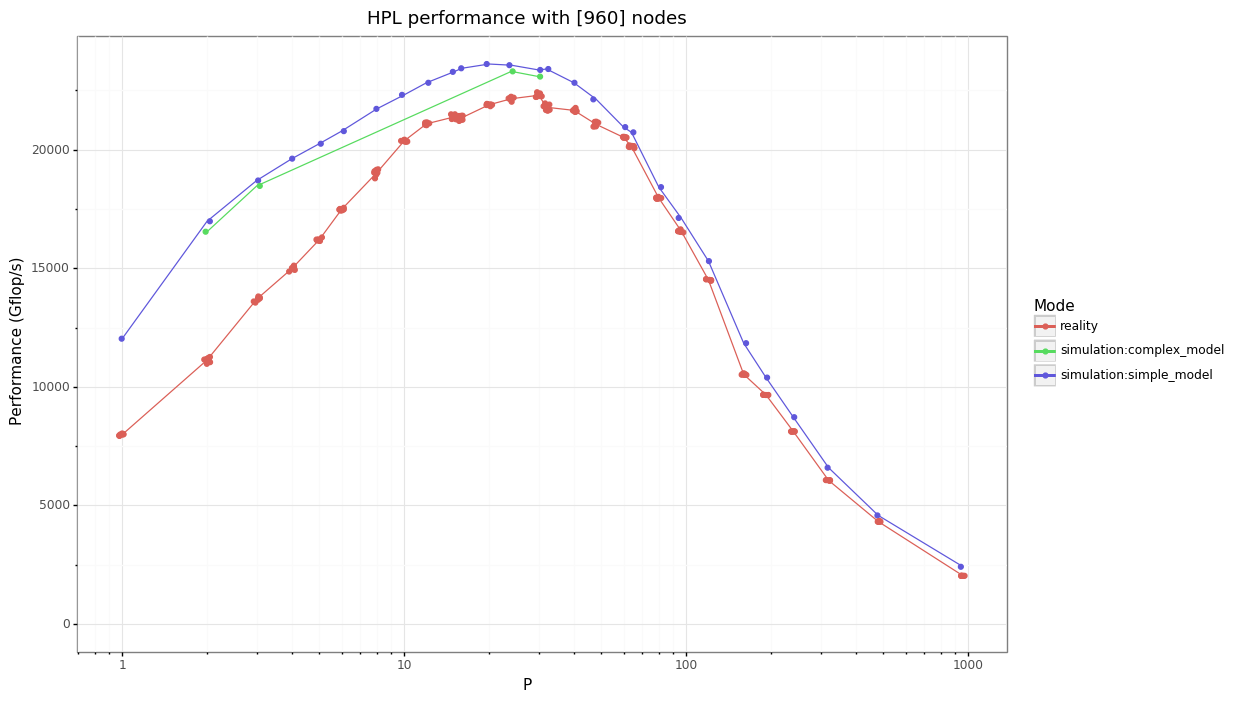

<ggplot: (8726817341686)>

In [6]:
df = df.reset_index(drop=True)
df['group'] = df['dgemm_file'].astype(str) + ':' + df['matrix_size'].astype(str) + ':' + df['mode'] + ':' + df['model'].astype(str)
df['color'] = df['mode']
df.loc[df['mode'] != 'reality', 'color'] += ':' + df['model'].astype(str)
(ggplot(df)
    + aes(x='proc_p', y='gflops', color='color', group='group')
    + stat_summary(geom='line')
    + geom_jitter()
    + theme_bw()
    + labs(x='P', y='Performance (Gflop/s)', color='Mode')
    + expand_limits(y=0)
    + scale_x_log10()
    + ggtitle(f'HPL performance with {df["nb_nodes"].unique()} nodes')
)

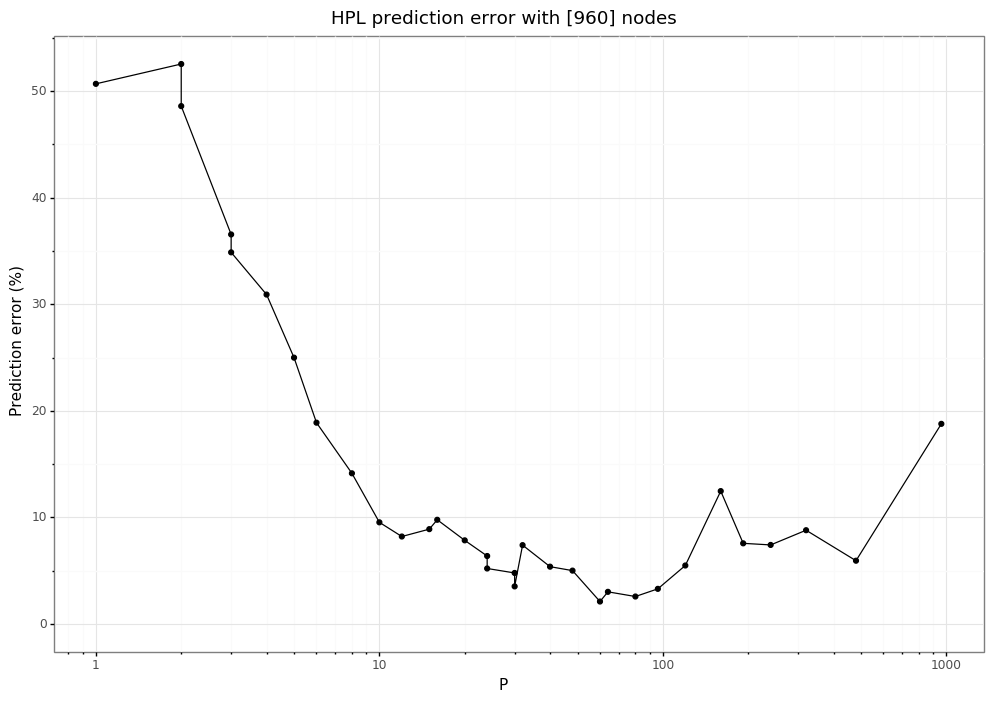

<ggplot: (-9223363310040046371)>

In [7]:
dfsim = df[df['mode'] == 'simulation'].copy()
dfreal = df[df['mode'] == 'reality'].groupby('proc_p')[['gflops']].mean()
dfsim = dfsim.set_index('proc_p').join(dfreal, rsuffix="_real").reset_index()
dfsim['error'] = round((dfsim['gflops'] / dfsim['gflops_real'] - 1)*100, 2)

(ggplot(dfsim)
    + aes(x='proc_p', y='error')
    + geom_line()
    + geom_point()
    + theme_bw()
    + labs(x='P', y='Prediction error (%)')
    + expand_limits(y=0)
    + scale_x_log10()
    + ggtitle(f'HPL prediction error with {df["nb_nodes"].unique()} nodes')
)

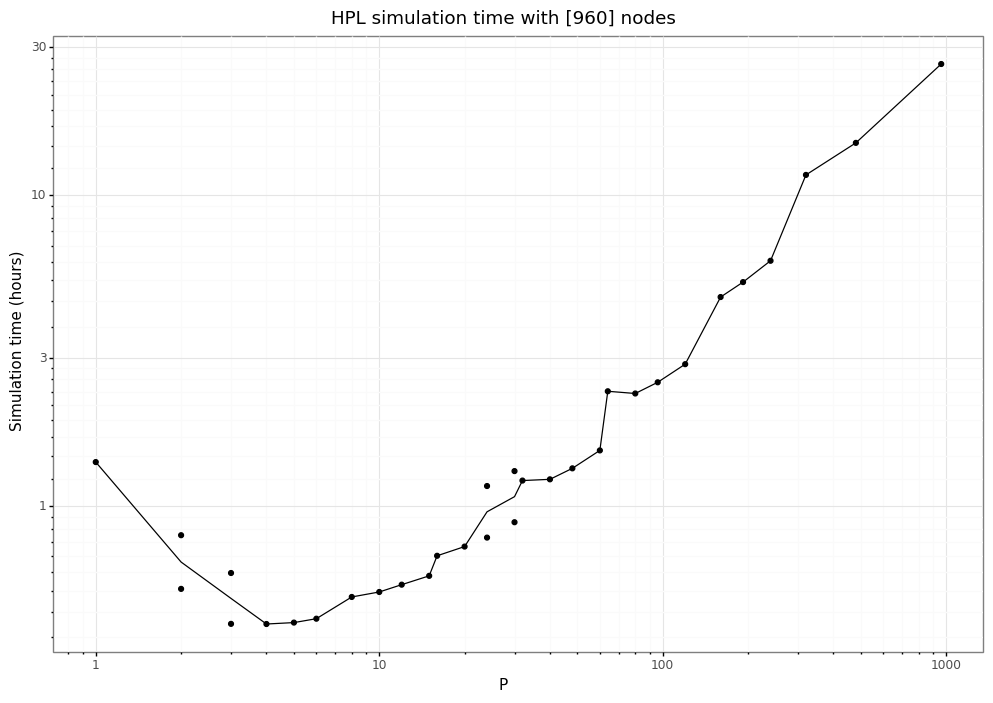

<ggplot: (-9223363310040042615)>

In [8]:
df['simtime'] = df['simulation_time'] / 3600
(ggplot(df[df['mode'] == 'simulation'])
    + aes(x='proc_p', y='simtime')
    + stat_summary(geom='line')
    + geom_point()
    + theme_bw()
    + labs(x='P', y='Simulation time (hours)')
    + expand_limits(y=0)
    + scale_x_log10()
    + scale_y_log10()
    + ggtitle(f'HPL simulation time with {df["nb_nodes"].unique()} nodes')
)

In [9]:
df['simtime'].max() / df['simtime'].min()

63.49259757738896